# Apple Stock Price Prediction using LSTM

In this code, we aim to predict Apple's stock prices for the entire year of 2023 using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network optimized for sequence prediction problems.

## Steps Covered:
1. **Data Retrieval**: Using the `yfinance` library, we fetch historical closing prices of Apple's stock from the beginning of 2020 to the end of October 2023.
2. **Data Preprocessing**:
    - The data is scaled using the `MinMaxScaler` to ensure the LSTM can more easily capture patterns in the data.
    - The data is then split into sequences of 60 days as input features with the next day's closing price as the target variable.
3. **Model Building**:
    - Our LSTM model consists of two LSTM layers.
    - This is followed by two dense layers with the last layer outputting a single value (the predicted stock price).
    - The model uses the `adam` optimizer and Mean Squared Error as the loss function.
4. **Training**: The model is trained using the data from 2020 to 2022.
5. **Prediction**: Using the trained model, predictions are made for the closing stock prices of Apple for the entirety of 2023.

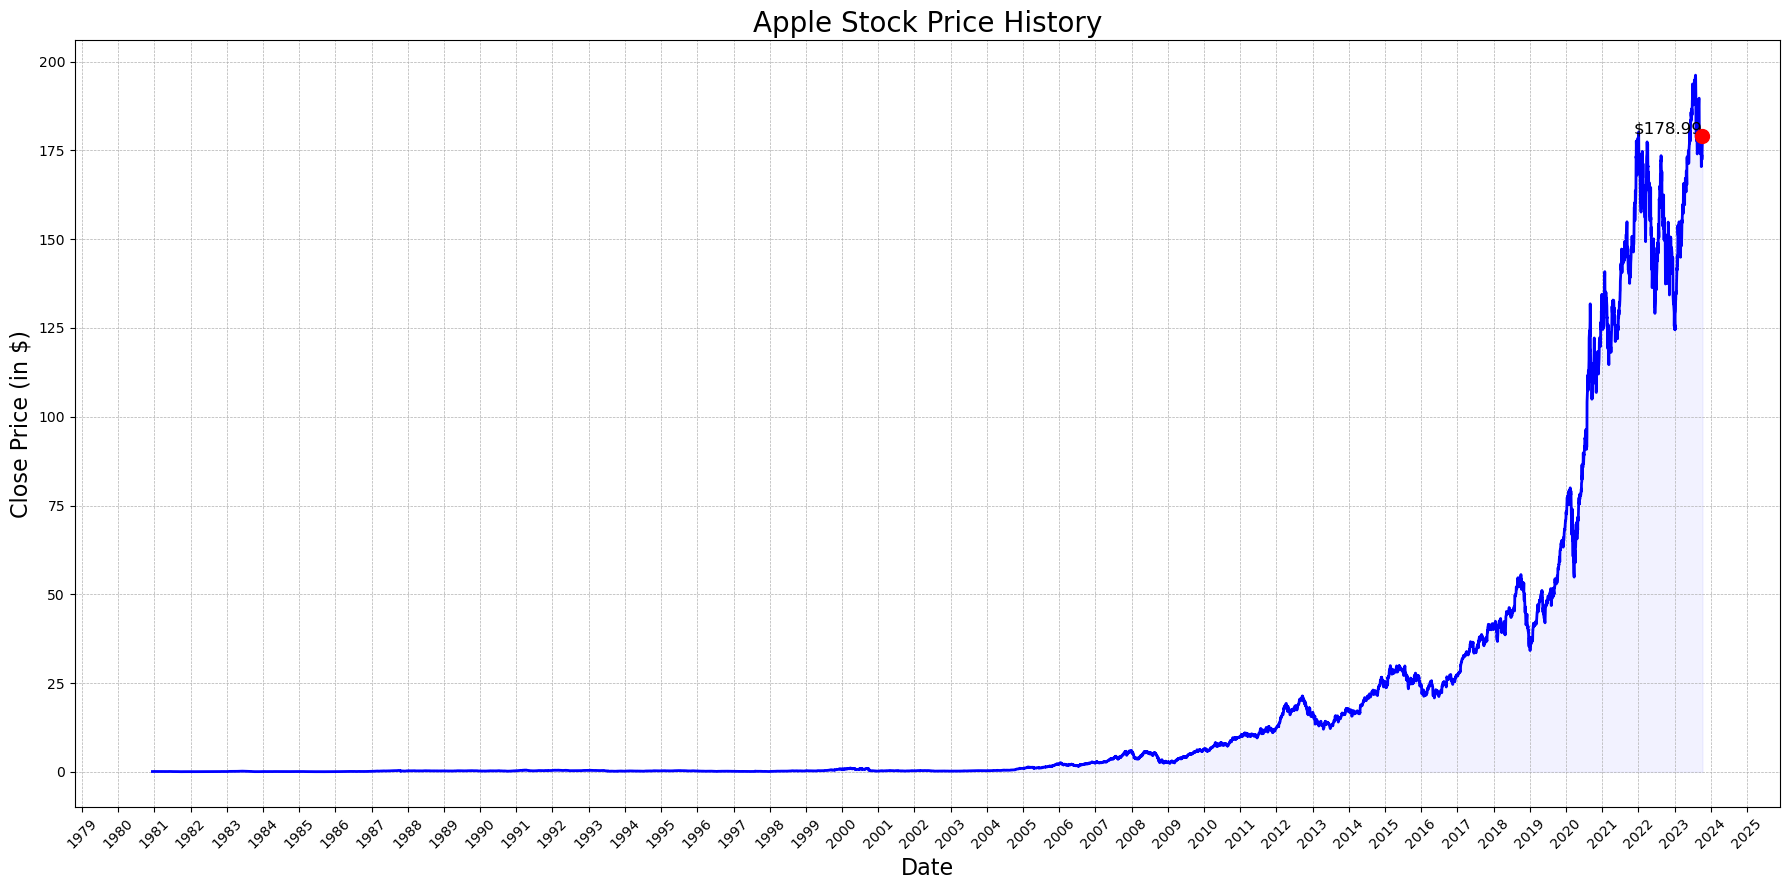

In [4]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Fetch Apple stock data from its inception till today
apple = yf.Ticker("AAPL")
df = apple.history(period="max")

# Plotting
plt.figure(figsize=(18, 9))
plt.plot(df.index, df['Close'], color='blue', lw=2)
plt.fill_between(df.index, df['Close'], color='blue', alpha=0.05)

# Highlight the latest closing price
latest_date = df.index[-1]
latest_price = df['Close'].iloc[-1]
plt.scatter(latest_date, latest_price, color='red', s=100, zorder=5)
plt.text(latest_date, latest_price, f'${latest_price:.2f}', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Title and labels
plt.title('Apple Stock Price History', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price (in $)', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


14/14 [==============================] - 1s 12ms/step


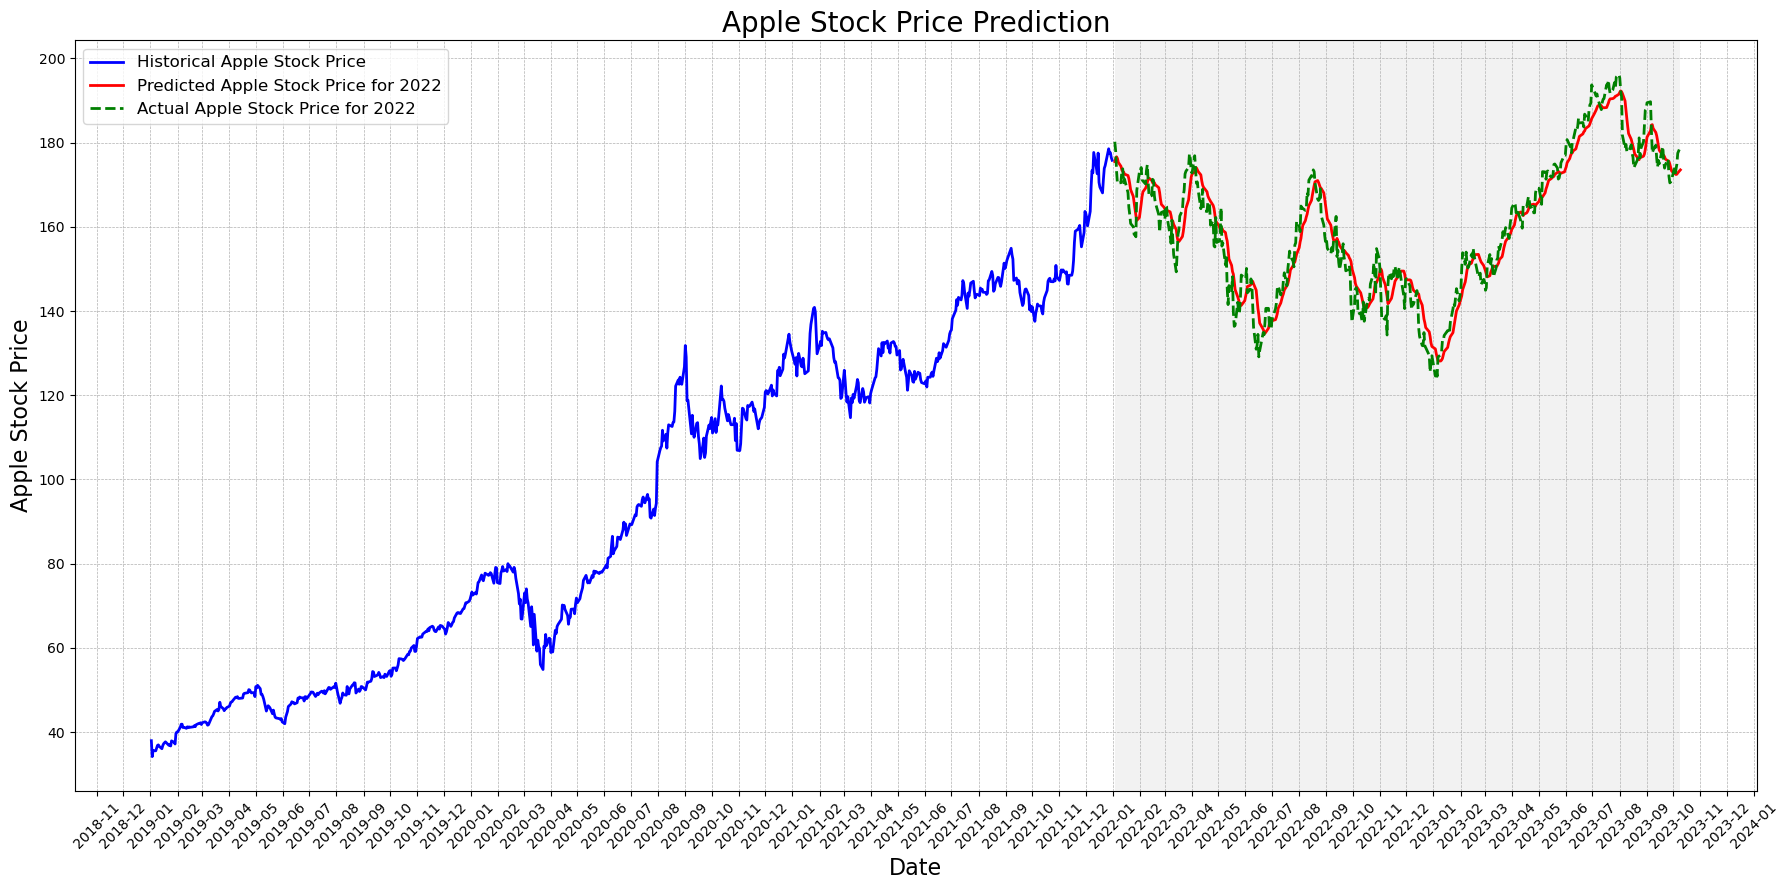

In [3]:
# Libraries & Setup
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import matplotlib.dates as mdates
import datetime

# Fetching Data from 2019 till today
apple = yf.Ticker("AAPL")
df = apple.history(start="2019-01-01")

# Data Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

prediction_days = 60  # Predict based on the last 60 days

x_train = []
y_train = []

tz = df.index.tz  # Get the timezone of the DataFrame index
end_2021 = len(df[df.index < datetime.datetime(2022, 1, 1, tzinfo=tz)])

for x in range(prediction_days, end_2021):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Improved Neural Network
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.3))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=0)  # verbose=0 suppresses the output

# Predictions for 2022
x_test = scaled_data[end_2021 - prediction_days:]

test_samples = []

for x in range(prediction_days, len(x_test)):
    test_samples.append(x_test[x-prediction_days:x, 0])

test_samples = np.array(test_samples)
test_samples = np.reshape(test_samples, (test_samples.shape[0], test_samples.shape[1], 1))

predicted_prices = model.predict(test_samples)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Enhanced Visualization
plt.figure(figsize=(18,9))
plt.plot(df.index[:end_2021], df['Close'].values[:end_2021], color='blue', label='Historical Apple Stock Price', lw=2)
plt.plot(df.index[end_2021:], predicted_prices, color='red', label='Predicted Apple Stock Price for 2022', lw=2)
plt.plot(df.index[end_2021:], df['Close'].values[end_2021:], color='green', label='Actual Apple Stock Price for 2022', lw=2, linestyle='--')
plt.axvspan(df.index[end_2021], df.index[-1], facecolor='gray', alpha=0.1)  # Highlight the prediction area
plt.title('Apple Stock Price Prediction', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Apple Stock Price', fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Model Assessment and Validation

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_prices = df['Close'].values[end_2021:end_2021+444]

mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): ${mse:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")


Mean Absolute Error (MAE): $160.22
Mean Squared Error (MSE): $25915.14
Root Mean Squared Error (RMSE): $160.98
